In [ ]:
!pip install transformers rouge-score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=390d4740ad9b361a0482d7fba0eaa2f98006537646f288520409948dda87a312
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, MT5ForConditionalGeneration
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from bert_score import score as bert_score

In [ ]:
import os
os.listdir('/kaggle/input')

['dataset-lowercase-clean']

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
file_paths = {
    'train': '/kaggle/input/dataset-lowercase-clean/train_data (1).csv',
    'test': '/kaggle/input/dataset-lowercase-clean/test_data (1).csv',
    'val': '/kaggle/input/dataset-lowercase-clean/val_data.csv'
}

# Fungsi untuk membaca dan melakukan tokenisasi pada data
def process_data(file_path):
    # Membaca CSV
    data = pd.read_csv(file_path)

    # Mengganti NaN dengan string kosong agar tokenizer bisa bekerja dengan data yang valid
    data['content'] = data['content'].fillna('')
    data['summary'] = data['summary'].fillna('')

    # Tokenisasi kolom 'content' dan 'summary' dengan padding dan attention mask otomatis
    input_encodings = tokenizer(
        data['content'].tolist(),
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    target_encodings = tokenizer(
        data['summary'].tolist(),
        max_length=150,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    # Menambahkan kolom tokenisasi ke DataFrame
    data['input_ids'] = input_encodings['input_ids'].tolist()
    data['attention_mask'] = input_encodings['attention_mask'].tolist()
    data['labels'] = target_encodings['input_ids'].tolist()

    return data[['content', 'summary', 'input_ids', 'attention_mask', 'labels']]

# Proses data untuk train, test, dan val
train_data = process_data(file_paths['train'])
test_data = process_data(file_paths['test'])
val_data = process_data(file_paths['val'])

train_data.head()

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

,content,summary,input_ids,attention_mask,labels
0,"ketua dewan pimpinan wilayah psi jakarta, elva...",psi menargetkan ridwan kamil-suswono menang sa...,"[67168, 262, 269, 3015, 421, 53414, 321, 6477,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101638, 107536, 1707, 502, 30003, 3015, 3156,..."
1,pt pelayaran nasional indonesia (persero) atau...,pt pelni (persero) sedang membuka lowongan ker...,"[259, 2766, 5174, 44901, 259, 61753, 31265, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[259, 2766, 5174, 516, 274, 24420, 2634, 271, ..."
2,shahnaz haque bercerita tentang kronologi meni...,"adik marissa haque, shahnaz haque mengungkapka...","[90400, 377, 360, 560, 921, 693, 72555, 259, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[74591, 1798, 5159, 560, 921, 261, 90400, 377,..."
3,bank indonesia (bi) mengajak investor china me...,bi mengajak investor china memanfaatkan peluan...,"[4896, 31265, 274, 1873, 271, 10612, 4652, 506...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[837, 10612, 4652, 50602, 39896, 416, 23553, 5..."
4,ketua bidang pelayanan pusat kedokteran dan ke...,pusdokkes polri masih kesulitan mengidentifika...,"[67168, 262, 330, 51933, 3932, 15893, 47560, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8165, 35476, 16954, 6553, 874, 259, 6885, 914..."


In [ ]:
train_data.to_csv('train_data_tokenized.csv', index=False)
test_data.to_csv('test_data_tokenized.csv', index=False)
val_data.to_csv('val_data_tokenized.csv', index=False)


In [ ]:
# Dataset Class (menggunakan token yang sudah ada)
class SummaryDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.data.iloc[idx]['input_ids']),
            'attention_mask': torch.tensor(self.data.iloc[idx]['attention_mask']),
            'labels': torch.tensor(self.data.iloc[idx]['labels'])
        }

# Membuat dataset untuk train, validation, dan test set
train_dataset = SummaryDataset(train_data)
val_dataset = SummaryDataset(val_data)
test_dataset = SummaryDataset(test_data)

# Membuat DataLoader untuk batch training
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [ ]:
from transformers import AdamW

# Menggunakan AdamW optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Inisialisasi jumlah epoch untuk pelatihan
num_epochs = 10

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch

train_losses_per_batch = []
val_losses_per_batch = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Proses Training
    model.train()
    total_train_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_losses_per_batch.append(loss.item())

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx+1}/{len(train_dataloader)} - Train Loss: {loss.item()}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Average Train Loss: {avg_train_loss}")

    torch.cuda.empty_cache()

    # Proses Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            val_losses_per_batch.append(loss.item())

            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx+1}/{len(val_dataloader)} - Validation Loss: {loss.item()}")

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Average Validation Loss: {avg_val_loss}")

    torch.cuda.empty_cache()


Epoch 1/10


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Batch 1/2082 - Train Loss: 49.941184997558594
Batch 11/2082 - Train Loss: 49.94965744018555
Batch 21/2082 - Train Loss: 51.94234848022461
Batch 31/2082 - Train Loss: 49.47040939331055
Batch 41/2082 - Train Loss: 49.225433349609375
Batch 51/2082 - Train Loss: 45.03831100463867
Batch 61/2082 - Train Loss: 44.90985870361328
Batch 71/2082 - Train Loss: 47.782615661621094
Batch 81/2082 - Train Loss: 45.87229919433594
Batch 91/2082 - Train Loss: 45.12067794799805
Batch 101/2082 - Train Loss: 45.071773529052734
Batch 111/2082 - Train Loss: 48.33816146850586
Batch 121/2082 - Train Loss: 43.07741165161133
Batch 131/2082 - Train Loss: 46.01950454711914
Batch 141/2082 - Train Loss: 40.63207244873047
Batch 151/2082 - Train Loss: 44.30917739868164
Batch 161/2082 - Train Loss: 42.330867767333984
Batch 171/2082 - Train Loss: 43.54225540161133
Batch 181/2082 - Train Loss: 40.2229118347168
Batch 191/2082 - Train Loss: 39.594242095947266
Batch 201/2082 - Train Loss: 37.929054260253906
Batch 211/2082 - T

In [ ]:
model.save_pretrained('/kaggle/working/mt5_small_model_clean')
tokenizer.save_pretrained('/kaggle/working/mt5_small_model_clean')

('/kaggle/working/mt5_small_model_clean/tokenizer_config.json',
 '/kaggle/working/mt5_small_model_clean/special_tokens_map.json',
 '/kaggle/working/mt5_small_model_clean/spiece.model',
 '/kaggle/working/mt5_small_model_clean/added_tokens.json',
 '/kaggle/working/mt5_small_model_clean/tokenizer.json')

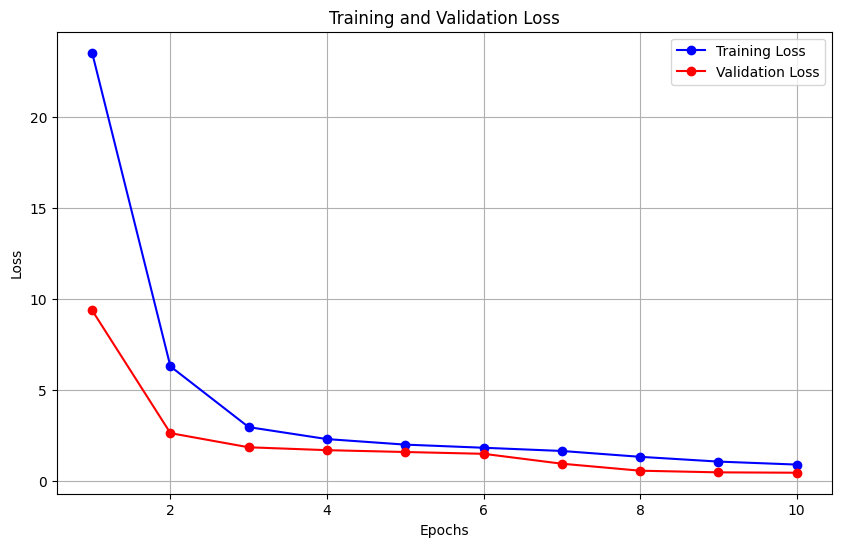

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='b', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='r', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

model.eval()
predictions, references, inputs = [], [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    # Generate summary
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=150,
        min_length=30,
        num_beams=4,
        no_repeat_ngram_size=2
    )

    # Decode predictions and references
    predictions.extend([tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                        for output in outputs])
    references.extend([tokenizer.decode(label, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                       for label in batch['labels']])
    inputs.extend([tokenizer.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                   for input_id in input_ids])

df_results = pd.DataFrame({
    'input': inputs,
    'predictions': predictions,
    'references': references
})
df_results.head()

# Save the results to a CSV file
df_results.to_csv('1generated_summaries.csv', index=False)

In [ ]:
from rouge_score import rouge_scorer
from bert_score import score as bert_score
# Evaluasi ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

for ref, pred in zip(references, predictions):
    score = scorer.score(ref, pred)
    rouge_scores["rouge1"].append(score["rouge1"].fmeasure)
    rouge_scores["rouge2"].append(score["rouge2"].fmeasure)
    rouge_scores["rougeL"].append(score["rougeL"].fmeasure)

avg_rouge1 = sum(rouge_scores["rouge1"]) / len(rouge_scores["rouge1"])
avg_rouge2 = sum(rouge_scores["rouge2"]) / len(rouge_scores["rouge2"])
avg_rougeL = sum(rouge_scores["rougeL"]) / len(rouge_scores["rougeL"])

print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")

# Evaluasi BERTScore
P, R, F1 = bert_score(predictions, references, lang="en")
print(f"Average BERTScore Precision: {P.mean().item()}")
print(f"Average BERTScore Recall: {R.mean().item()}")
print(f"Average BERTScore F1: {F1.mean().item()}")

Average ROUGE-1: 0.3037951265857941
Average ROUGE-2: 0.1647139612159499
Average ROUGE-L: 0.26592791777050184


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore Precision: 0.8498234152793884
Average BERTScore Recall: 0.8606154918670654
Average BERTScore F1: 0.8550535440444946


In [ ]:
!pip install huggingface_hub

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from huggingface_hub import login

# Login dengan token Hugging Face
login(token="")

In [ ]:
from huggingface_hub import create_repo

# Membuat repository
repo_name = 'clean-model-mt5-small-10epoch'
create_repo(repo_name)

RepoUrl('https://huggingface.co/intanutami/clean-model-mt5-small-10epoch', endpoint='https://huggingface.co', repo_type='model', repo_id='intanutami/clean-model-mt5-small-10epoch')

In [ ]:
from huggingface_hub import upload_folder

# Upload model ke repository yang sudah ada
upload_folder(
    repo_id='intanutami/clean-model-mt5-small-10epoch',
    folder_path='/kaggle/working/mt5_small_model_clean',
    commit_message="Upload my trained model"
)

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/intanutami/clean-model-mt5-small-10epoch/commit/537caf5c7cfd74df9f17f38b2f4d311b89b66aab', commit_message='Upload my trained\xa0model', commit_description='', oid='537caf5c7cfd74df9f17f38b2f4d311b89b66aab', pr_url=None, repo_url=RepoUrl('https://huggingface.co/intanutami/clean-model-mt5-small-10epoch', endpoint='https://huggingface.co', repo_type='model', repo_id='intanutami/clean-model-mt5-small-10epoch'), pr_revision=None, pr_num=None)